# Amazon Personalize 사용자 세분화

Amazon Personalize는 다양한 제품 범주, 브랜드 등에 대한 사용자의 관심도에 따라 사용자를 세분화하는 두 가지 레시피를 제공합니다.
1. 항목 선호도 레시피 `aws-item-affinity`는 영화, 노래, 제품 등, 카탈로그의 개별 항목에 대한 관심도에 따라 사용자를 식별합니다.
1. 항목 속성 선호도 레시피 `aws-item-attribute`는 장르, 브랜드 등, 카탈로그 내 항목의 속성을 기준으로 사용자를 식별합니다. 이 레시피를 사용하면 사용자의 마케팅 캠페인 참여를 보다 효과적으로 유도하고, 타겟팅된 메시징을 통해 고객 유지율을 개선할 수 있습니다.

이 노트북은 `aws-item-affinity` 및 `aws-item-attribute` 레시피를 사용하여 Amazon Prime Pantry 데이터 세트의 식료품에 대한 사용자의 선호도에 따라 사용자 세그먼트를 생성하는 방법을 보여줍니다. 여기서는 사용자-항목 상호 작용 데이터와 항목 메타데이터가 포함된 단일 데이터 세트 그룹을 사용합니다. 이러한 데이터 세트와 두 가지 레시피를 사용하여 솔루션을 훈련하고 사용자 세그먼트를 배치 생성합니다.


이 노트북은 다음 아키텍처의 배포 과정을 안내합니다.

![](user_segmentation.png)

위에서 보듯이 다음 리소스를 배포합니다.
1. S3 버킷은 훈련 파일과 추론 입력 파일 및 출력 파일을 저장하는 데 사용됩니다.
1. 데이터 세트 그룹
1. 2개의 데이터 세트 - 상호 작용 및 항목
1. 각각의 새로운 사용자 세분화 레시피로 구성된 2개의 솔루션과 솔루션 버전
1. 2개의 배치 추론 작업

배치 추론 작업 결과가 나오면 결과를 분석합니다.

## 데이터 로드 및 처리
Prime Pantry 데이터 세트를 로드하는 것으로 시작하겠습니다. 데이터 파일에 액세스하려면 다음 양식을 작성해야 합니다.

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

Citation:

    Justifying recommendations using distantly-labeled reviews and fined-grained aspects
    Jianmo Ni, Jiacheng Li, Julian McAuley
    Empirical Methods in Natural Language Processing (EMNLP), 2019 pdf

In [1]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import boto3
import time
from time import sleep
from lxml import html
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import datetime as dt

In [2]:
data_dir = 'raw_data'
!mkdir $data_dir

!cd $data_dir && \
    wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Grocery_and_Gourmet_Food.json.gz && \
    wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Grocery_and_Gourmet_Food.json.gz

--2021-11-26 02:58:20--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Grocery_and_Gourmet_Food.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 586910426 (560M) [application/octet-stream]
Saving to: ‘Grocery_and_Gourmet_Food.json.gz’

Grocery_and_Gourmet 100%[===================>] 559.72M  83.2MB/s    in 7.0s    

2021-11-26 02:58:27 (80.3 MB/s) - ‘Grocery_and_Gourmet_Food.json.gz’ saved [586910426/586910426]

--2021-11-26 02:58:27--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Grocery_and_Gourmet_Food.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109586529 (105M) [application/octet-stream]
Saving to: ‘meta_Grocery_and_Gourmet_Food.json.gz’

me

### 항목 메타데이터를 로드하고 살펴보기
먼저 Prime Pantry 제품에 대한 항목 메타데이터를 로드하고 몇 가지 명령을 실행하여 작업 내용을 살펴보겠습니다.

In [9]:
meta=pd.read_json(data_dir + '/meta_Grocery_and_Gourmet_Food.json.gz',lines=True,compression='infer')
#remove duplicated items and items without item title
meta=meta.rename(columns={'asin':'ITEM_ID'}).drop_duplicates(subset=['ITEM_ID'], keep='last')
meta = meta[meta.title.notnull()]
print('After removing items without title: {}'.format(meta.shape))

After removing items without title: (283354, 19)


283,354개의 레코드와 19개의 열이 있습니다.

그런 다음 항목 설명의 형식을 지정하고 제목과 결합하여 텍스트 특성으로 사용하고, 이 텍스트 특성이 있는 항목만 유지합니다.

In [10]:
def process_description(description):    
    description = description.replace('<p>&nbsp;</p>', '') # remove &nbsp from the text
    description = description.replace('<p></p>', '') # remove <p></p> from the text
    description = description.replace('<p> </p>', '') # remove <p> </p> from the text
    
    # remove hyper links form the text
    import re
    a_pattern = re.compile('<a.*?>')
    description = re.sub(a_pattern, '', description)
    description = description.replace('</a>', '')
    
    # remove spans from the text
    span_pattern = re.compile('<span.*?>')
    description = re.sub(span_pattern, '', description)
    description = description.replace('</span>', '')
    
    # remove <b> and </b> from the text
    description = description.replace('<b>', '')
    description = description.replace('</b>', '')
    
    # remove .  . and \n from the text
    description = description.replace('\n', '')
    
    # remove HTML
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    description = re.sub(cleanr, '', description)
    
    # remove extra space etc.
    description = ' '.join(description.split())
    
    # specifics for Amazon dataset
    description = description.replace('.  .', '')
    
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(description)
    text = soup.find_all(text = True)
    
    for index, t in enumerate(text):
        if t[-1] != '.':
            text[index] += '.'
    
    return ' '.join(text).strip()
meta['description']=meta.apply(lambda x:process_description(x['title']+' '+' '.join(x['description'])),axis=1)
meta=meta[meta['description'].apply(len)>0]
print("Done cleaning the description")

Done cleaning the description


그런 다음 항목 가격의 형식을 지정하고, 데이터 세트 열을 삭제하거나 그 이름을 변경하고, 메타데이터 데이터 프레임 모양을 인쇄합니다.

In [11]:
#formatting price
def convert_price(row):
    v = str(row['price']).strip().replace('$', '')
    if v == '' or not v.lstrip('-').replace('.', '').isdigit():
        return np.nan
    return v
meta['price'] = meta.apply(convert_price, axis=1)
meta=meta[['category','brand','main_cat','description','price','ITEM_ID']].set_index('ITEM_ID')
meta.rename(columns = {'category':'CATEGORY', 'brand':'BRAND', 'main_cat':'MAIN_CAT',
                              'price':'PRICE', 'description': 'DESCRIPTION'}, inplace = True)
print('Items with non-empty description+title: {}'.format(meta.shape))

Items with non-empty description+title: (283352, 5)


항목을 많이 삭제하지 않았는데도 이제 열이 5개밖에 없습니다.
범주 열을 만들고 데이터를 조금 더 정리하겠습니다.

In [12]:
unique_category=meta['CATEGORY'].explode().value_counts()
popular_category=unique_category[unique_category>1].reset_index()

#remove category values with longer than 38 char
popular_category=popular_category[popular_category['index'].apply(len)<38]
valid_category=set(popular_category['index'].values)
meta['CATEGORY']=meta['CATEGORY'].apply(lambda x:list(set(x)& valid_category))

#format category values into single string separated by |
meta['CATEGORY']=meta['CATEGORY'].apply(lambda x:'|'.join(x))
meta.sample(3)

,CATEGORY,BRAND,MAIN_CAT,DESCRIPTION,PRICE
ITEM_ID,,,,,
B00BRAY3KK,Grocery & Gourmet Food|Cooking & Baking|Xylito...,Xyla Brand,Grocery,"Xyla Brand Erythritol Sweetener, 1 Pound 1lb E...",NaN
B010PABSO6,Snack Foods|Grocery & Gourmet Food|Potato|Chip...,Special K,Grocery,"Kellogg's Special K, Cracker Chips, Sour Cream...",NaN
B00GQSX5MK,Cooking & Baking|Extracts & Flavoring|Grocery ...,Chef O Van,Grocery,"Chef-O-Van Natural Flavoring Extracts, Pure Va...",NaN


나중에 Amazon Personalize 배포를 훈련하는 데 사용할 수 있도록, 이제 항목 메타데이터를 로컬로 저장하겠습니다.

In [13]:
## Storing items with description only
items_with_desc_only_filename = "items-only-desc.csv"
meta[['DESCRIPTION']].to_csv(items_with_desc_only_filename, index=True, float_format='%.2f')

## Storing items with all the metadata
items_fullmeta_filename = "items-full-meta.csv"
meta.to_csv(items_fullmeta_filename, index=True, float_format='%.2f')

## Storing items without description
items_meta_filename = "items-nontextual-meta.csv"
meta.drop(columns=['DESCRIPTION']).to_csv(items_meta_filename, index=True, float_format='%.2f')


### 리뷰 데이터 로드 및 상호 작용 데이터 세트 구축
다음으로, 리뷰 데이터를 로드한 후, 필요하지 않은 열을 제거하고 데이터 세트 스키마에 맞게 형식을 지정하여 상호 작용 데이터 세트를 구축합니다.

In [14]:
events_df = pd.read_json(data_dir + '/Grocery_and_Gourmet_Food.json.gz', lines=True, compression='infer')
events_df = events_df[['reviewerID', 'asin', 'unixReviewTime']].rename(columns = {'reviewerID':'USER_ID', 'asin':'ITEM_ID', 
                              'unixReviewTime':'TIMESTAMP'})
events_df.drop_duplicates(inplace=True)
events_df.sample(3)

,USER_ID,ITEM_ID,TIMESTAMP
2731959,AU3BUD6KKPM20,B00H3TBDE8,1409961600
1651923,A1N9W68A44N3NK,B0050WVLII,1504396800
2851971,A1KAAIOTWIEDHD,B00ISL461C,1445904000


3건 이상의 상호 작용이 있는 사용자를 유지하겠습니다.

In [15]:
events_df = events_df[events_df.ITEM_ID.isin(set(meta.index))]
user_len=events_df.groupby(by='USER_ID')['TIMESTAMP'].count()
valid_users=set(user_len[user_len>3].index)
events_df=events_df[events_df.USER_ID.isin(valid_users)]
print("number of total interactions:{} num users:{} num items:{} ".format(len(events_df),len(events_df['USER_ID'].unique()),len(events_df['ITEM_ID'].unique())))

number of total interactions:1701476 num users:230558 num items:187437 


마지막으로, 처리된 상호 작용 데이터를 CSV에 저장합니다.

In [16]:
events_df = events_df.sort_values(['USER_ID', 'TIMESTAMP'], kind='mergesort')
events_df.to_csv("all_interactions.csv", index=False)

### 훈련 및 테스트 데이터 분할

솔루션의 성능을 테스트하기 위해 상호 작용 데이터를 훈련 세트와 보류 테스트 세트로 분할합니다. Amazon PrimePantry 데이터 세트에는 2000-08-09부터 2018-10-05까지 약 18년에 걸친 약 170만 건의 상호 작용 데이터가 있습니다. 가장 최근의 상호 작용 중 5%를 보류하고 나머지 95%에 대해 훈련합니다. 결과적으로, 2000-08-09부터 2018-02-01까지의 상호 작용을 사용하여 솔루션을 훈련하고, 나머지 8개월 간의 상호 작용을 실측 데이터로 사용하여 미래의 활동을 시뮬레이션하는 분할이 이루어집니다.

Text(0.5, 1.0, 'num interactions over time')

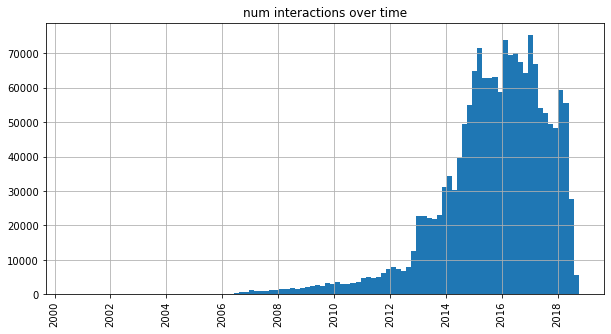

In [17]:
plt.figure(figsize=(10,5))
events_df['TIMESTAMP'].astype('datetime64[s]').hist(bins=100,xrot=90)
plt.title('num interactions over time')

In [18]:
test_start_date  = [2018,2,1]
test_start  = dt.datetime(*test_start_date).timestamp()
train_df=events_df[events_df['TIMESTAMP']<test_start]
test_df=events_df[events_df['TIMESTAMP']>=test_start]
warm_user=set(train_df['USER_ID'].unique())&set(test_df['USER_ID'].unique())
print('number of train users:{}'.format(len(train_df['USER_ID'].unique())))
print('number of warm test users who have non-empty interaction in TRAIN:{}'.format(len(warm_user)))
print('number of total users in TEST:{}, removed {} cold users from TEST'.format(len(test_df['USER_ID'].unique()),len(test_df['USER_ID'].unique())-len(warm_user)))
test_df=test_df[test_df['USER_ID'].isin(warm_user)]

number of train users:226200
number of warm test users who have non-empty interaction in TRAIN:51254
number of total users in TEST:55612, removed 4358 cold users from TEST


처리된 훈련 상호 작용 데이터를 CSV에 저장

In [19]:
interactions_filename = "interactions.csv"
train_df.to_csv(interactions_filename, index=False)

### 개인화 API 모델 Json 및 Personalize Boto3 클라이언트 가져오기

In [21]:
# Copy personalize.normal.json to the same directly
# the file can be found from drive: https://drive.corp.amazon.com/documents/hydro@/personalize.normal.json
!aws configure add-model --service-model file://`pwd`/personalize.normal.json --service-name personalize

In [99]:
import boto3
import json
import numpy as np
import pandas as pd
import time

personalize = boto3.client(service_name = 'personalize')
s3 =boto3.client('s3')

### 헬퍼 함수
다음 헬퍼 함수는 나중에 노트북에서 사용됩니다.

In [23]:
def print_s3_file_content(bucket, key, limit=None):
    obj = s3.get_object(Bucket=bucket, Key=key)

    i = 0
    for line in obj['Body'].read().decode("utf-8").split("\n"):
        print(line)
        i+=1
        if limit is not None and i > limit:
            break

max_time = time.time() + 3 * 60 * 60 # 3 hours

def wait_for_dataset_group_job(dataset_group_arn):
    max_time = time.time() + 3 * 60 * 60
    while time.time() < max_time:
        describe_dataset_group_response = personalize.describe_dataset_group(
            datasetGroupArn = dataset_group_arn
        )
        status = describe_dataset_group_response["datasetGroup"]["status"]
        print("DatasetGroup: {}".format(status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(60)
        
def wait_for_dataset_import_job(dataset_import_job_arn):
    max_time = time.time() + 3 * 60 * 60
    while time.time() < max_time:
        describe_dataset_import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = dataset_import_job_arn
        )
        status = describe_dataset_import_job_response["datasetImportJob"]['status']
        print("DatasetImportJob: {}".format(status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(120)
            
def wait_for_solution_version_job(solution_version_arn):
    max_time = time.time() + 3 * 60 * 60
    while time.time() < max_time:
        describe_solution_version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = describe_solution_version_response["solutionVersion"]["status"]
        print("SolutionVersion: {}".format(status))

        start = describe_solution_version_response["solutionVersion"]["creationDateTime"]
        end = describe_solution_version_response["solutionVersion"]["lastUpdatedDateTime"]
        if status == "ACTIVE":
            print("Time took: {}".format(end - start))
            break
        if status == "CREATE FAILED":
            print("Time took: {}".format(end - start))
            print("Job Failed: {}".format(describe_solution_version_response["solutionVersion"]["failureReason"]))
            break

        time.sleep(180)
        
def wait_for_batch_segment_job(batch_segment_job_arn):
    max_time = time.time() + 3 * 60 * 60
    while time.time() < max_time:
        describe_job_response = personalize.describe_batch_segment_job(
            batchSegmentJobArn = batch_segment_job_arn
        )
        status = describe_job_response["batchSegmentJob"]["status"]
        print("Batch Segment Job: {}".format(status))

        start = describe_job_response["batchSegmentJob"]["creationDateTime"]
        end = describe_job_response["batchSegmentJob"]["lastUpdatedDateTime"]
        if status == "ACTIVE":
            print("Time took: {}".format(end - start))
            break
        if status == "CREATE FAILED":
            print("Time took: {}".format(end - start))
            print("Job Failed: {}".format(describe_job_response["batchSegmentJob"]["failureReason"]))
            break

        time.sleep(180)
        
        
def import_dataset(job_name, dataset_arn, data_s3_url, role_arn):
    max_time = time.time() + 3 * 60 * 60
    dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = job_name,
        datasetArn = dataset_arn,
        dataSource = {
            "dataLocation": data_s3_url 
        },
        roleArn = role_arn
    )

    dataset_import_job_arn = dataset_import_job_response['datasetImportJobArn']
    print(dataset_import_job_arn)
    
    wait_for_dataset_import_job(dataset_import_job_arn)

# 항목 선호도 레시피

항목 선호도 레시피는 특정 항목과 상호 자굥ㅇ할 가능성이 있는 사용자를 추천합니다.
### 참고:
* 2단계로 건너뛰세요. 데이터 세트 그룹이 이미 생성되어 있는 경우 솔루션 생성
* 3단계로 건너뛰세요. 솔루션 버전이 이미 훈련되어 있고 필터 없이 쿼리하려는 경우 배치 세그먼트 생성
* 4단계로 건너뛰세요. 솔루션 버전이 이미 훈련되어 있고 필터를 사용하여 테스트하려는 경우 필터링

## 1. 데이터 세트 그룹 및 데이터 세트를 생성하고 데이터 세트 업로드

### 1.1 스키마 생성

In [24]:
interactions_schema = {
  "type": "record",
  "name": "Interactions",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
    {
      "name": "USER_ID",
      "type": "string"
    },
    {
      "name": "ITEM_ID",
      "type": "string"
    },
    {
      "name": "TIMESTAMP",
      "type": "long"
    }
  ],
  "version": 1
}

create_schema_response = personalize.create_schema(
    name = "notebook-amazon-grocery-meta-interaction-schema-demo",
    schema = json.dumps(interactions_schema)
)

interactions_schema_arn = create_schema_response['schemaArn']
print(interactions_schema_arn)

arn:aws:personalize:us-west-2:144386903708:schema/notebook-amazon-grocery-meta-interaction-schema-demo


In [25]:
items_schema = {
  "type": "record",
  "name": "Items",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
    {
      "name": "ITEM_ID",
      "type": "string"
    },
    {
      "name": "DESCRIPTION",
      "type": [
        "string",
        "null"
      ],
      "textual": True
    }
  ],
  "version": 1
}

create_schema_response = personalize.create_schema(
    name = "notebook-amazon-grocery-meta-item-schema-demo",
    schema = json.dumps(items_schema)
)

items_schema_arn = create_schema_response['schemaArn']
print(items_schema_arn)

arn:aws:personalize:us-west-2:144386903708:schema/notebook-amazon-grocery-meta-item-schema-demo


### 1.2 데이터 세트 그룹 생성

In [26]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "notebook-amazon-grocery-meta-demo"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(dataset_group_arn)

arn:aws:personalize:us-west-2:144386903708:dataset-group/notebook-amazon-grocery-meta-demo


#### 데이터 세트 그룹이 활성 상태가 될 때까지 기다리기

In [27]:
wait_for_dataset_group_job(dataset_group_arn)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### 1.3 데이터 세트 생성

In [28]:
create_dataset_response = personalize.create_dataset(
    name = "interactions",
    datasetType = "INTERACTIONS",
    datasetGroupArn = dataset_group_arn,
    schemaArn = interactions_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(interactions_dataset_arn)

arn:aws:personalize:us-west-2:144386903708:dataset/notebook-amazon-grocery-meta-demo/INTERACTIONS


In [29]:
create_dataset_response = personalize.create_dataset(
    name = "items",
    datasetType = "ITEMS",
    datasetGroupArn = dataset_group_arn,
    schemaArn = items_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(items_dataset_arn)

arn:aws:personalize:us-west-2:144386903708:dataset/notebook-amazon-grocery-meta-demo/ITEMS


### 1.4 데이터 세트 가져오기 작업 생성

In [30]:
# Determine the current S3 region where this notebook is being hosted in SageMaker.
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-west-2


#### 1.4.1 [이미 생성된 경우 선택 사항] S3 버킷 생성

In [31]:
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "-" + region + "-" + "personalize-user-segmentation-demo"
print(bucket_name)
if region == "us-east-1":
    s3.create_bucket(Bucket=bucket_name)
else:
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region}
    )

144386903708-us-west-2-personalize-user-segmentation-demo


#### 설명이 있는 상호 작용 및 항목만 S3에 업로드

In [32]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_filename)
boto3.Session().resource('s3').Bucket(bucket_name).Object(items_with_desc_only_filename).upload_file(items_with_desc_only_filename)

#### 1.4.2 [이미 연결된 경우 선택 사항] Personalize가 액세스할 수 있도록 버킷 정책 연결

In [33]:
s3 = boto3.client("s3")
bucket = bucket_name
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket",
                "s3:PutObject"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}
# uncomment if this policy has not been attached to the bucket
s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': '1W51Y6AMS72DV9QW',
  'HostId': 'O4tTBmulKx+gz0htR7Xf7/PtBLYAB64BA+elATp6utWjbU0BmLy5Mb/O3hd/UfOHVaVJdRnsG8U=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'O4tTBmulKx+gz0htR7Xf7/PtBLYAB64BA+elATp6utWjbU0BmLy5Mb/O3hd/UfOHVaVJdRnsG8U=',
   'x-amz-request-id': '1W51Y6AMS72DV9QW',
   'date': 'Fri, 26 Nov 2021 03:26:11 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

#### 1.4.3 [이미 생성된 경우 선택 사항] Personalize FullAccess 및 S3 FullAccess가 부여된 Personalize 역할 생성

In [34]:
iam = boto3.client("iam")
role_name = "MyNotebookPersonalizeRoleDemo"+account_id
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::144386903708:role/MyNotebookPersonalizeRoleDemo144386903708


### 1.5 데이터 세트 가져오기 작업 생성

#### 1.5.1 1.4.2에서 지정한 역할과 1.4.3에서 준비한 데이터로 가져오기 작업 생성

In [ ]:
interactions_s3_url = "s3://"+bucket_name+"/"+interactions_filename
import_dataset("notebook-ag-inters-import", interactions_dataset_arn, interactions_s3_url, role_arn)

In [ ]:
items_s3_url =        "s3://"+bucket_name+"/"+items_with_desc_only_filename
import_dataset("notebook-items-textual-import", items_dataset_arn, items_s3_url, role_arn)

## 2. 솔루션 생성

#### 2.1 항목 선호도 레시피 선택

In [38]:
item_user_recipe = 'arn:aws:personalize:::recipe/aws-item-affinity'

### 2.2 솔루션 생성

In [39]:
create_solution_response = personalize.create_solution(
    name = "item-affinity-amazon-grocery-meta-demo",
    datasetGroupArn = dataset_group_arn,
    recipeArn = item_user_recipe,
)
solution_arn = create_solution_response['solutionArn']

In [40]:
personalize.describe_solution(solutionArn = solution_arn)

{'solution': {'name': 'item-affinity-amazon-grocery-meta-demo',
  'solutionArn': 'arn:aws:personalize:us-west-2:144386903708:solution/item-affinity-amazon-grocery-meta-demo',
  'performHPO': False,
  'performAutoML': False,
  'recipeArn': 'arn:aws:personalize:::recipe/aws-item-affinity',
  'datasetGroupArn': 'arn:aws:personalize:us-west-2:144386903708:dataset-group/notebook-amazon-grocery-meta-demo',
  'status': 'ACTIVE',
  'creationDateTime': datetime.datetime(2021, 11, 26, 3, 38, 23, 645000, tzinfo=tzlocal()),
  'lastUpdatedDateTime': datetime.datetime(2021, 11, 26, 3, 38, 23, 645000, tzinfo=tzlocal())},
 'ResponseMetadata': {'RequestId': 'e0d5e15c-7a5d-42b9-a37a-a30500d9afe7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 26 Nov 2021 03:38:24 GMT',
   'x-amzn-requestid': 'e0d5e15c-7a5d-42b9-a37a-a30500d9afe7',
   'content-length': '475',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### 2.3 솔루션 버전 생성

In [41]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)
solution_version_arn = create_solution_version_response['solutionVersionArn']
print(solution_version_arn)

arn:aws:personalize:us-west-2:144386903708:solution/item-affinity-amazon-grocery-meta-demo/e27b6a08


#### 솔루션 버전이 활성 상태가 될 때까지 기다리기

In [43]:
wait_for_solution_version_job(solution_version_arn)

SolutionVersion: ACTIVE
Time took: 2:15:34.850000


### 2.4 지표 가져오기
참고: 이러한 지표는 여러 솔루션 버전에 걸쳐 결과를 평가하는 데 사용되는 Amazon Personalize의 오프라인 지표입니다. 데이터를 사전 처리할 때 구축한 테스트 데이터 세트에서 도출할 지표와 혼동해서는 안 됩니다.

In [44]:
get_solution_metrics_response = personalize.get_solution_metrics(solutionVersionArn=solution_version_arn)
print(get_solution_metrics_response['metrics'])

{'coverage': 0.6835, 'hits_at_1_percent': 0.323, 'recall_at_1_percent': 0.0752}


## 3. 배치 세그먼트 작업 생성
테스트 세트에서 무작위로 선택한 500개 항목에 대해 aws-item-affinity 솔루션을 실행하여 사용자 2,262명(데이터 세트에 있는 사용자의 1%)의 목록을 쿼리합니다. 그런 다음 테스트 세트를 사용하여, 테스트 기간 동안 2,262명의 사용자가 얼마나 자주 항목을 구입했는지 평가합니다. 비교를 위해 테스트 기간 동안 가장 활동이 많은 사용자 2,262명이 얼마나 자주 항목을 구입했는지도 평가합니다.

### 3.1 테스트 세트 실측 데이터에서 입력 쿼리 데이터 준비

In [45]:
groundtruth=test_df.groupby('ITEM_ID')['USER_ID'].unique()
#sample 500 items from test data as test queries
test_labels=groundtruth.sample(n=500,random_state=10)
test_labels.reset_index()[['ITEM_ID']].rename(columns={'ITEM_ID':'itemId'}).to_json('query-amazon-grocery.json',orient='records',lines=True)
test_labels=test_labels.to_frame('target_users')
test_labels

,target_users
ITEM_ID,
B00DIBYDCY,[A12E83IRM13GQW]
B007JCXVF8,"[A171SOU49WBY9Q, A1NBWNGTFAVQ35, A2BDPU4K4RIQH..."
B00IEGNPTA,[A1QBYVDQ0V6HAR]
B00FQR6IDU,[A1Y7YWTOLRWTDJ]
B00OLDP5KC,[A3GAHEYWEGLYS1]
...,...
B01F192YFI,[A28RBB909ZNR8F]
B00099XLEE,[A2R9Z7VI5GAQGR]
B00V8B5RXK,[ANW9IX7324JYR]


In [46]:
# example json lines in the input file:
# {"itemId": "1"}
# {"itemId": "2"}
# {"itemId": "3"}
# ...
batch_file_name = 'query-amazon-grocery.json'
boto3.Session().resource('s3').Bucket(bucket_name).Object(batch_file_name).upload_file(batch_file_name)
batch_input_path = "s3://"+bucket_name+"/"+batch_file_name
batch_output_path = "s3://"+bucket_name+"/output/"
print_s3_file_content(bucket=bucket_name, key=batch_file_name,limit=3)
# these are the file contents

{"itemId":"B00DIBYDCY"}
{"itemId":"B007JCXVF8"}
{"itemId":"B00IEGNPTA"}
{"itemId":"B00FQR6IDU"}


**고유 사용자의 수를 인쇄해보겠습니다.**

In [47]:
topk=len(train_df['USER_ID'].unique())//100
topk

2262

### 3.2 배치 세그먼트 작업 생성

In [48]:
# change the jobName if already exists
create_batch_segment_response = personalize.create_batch_segment_job(
    jobName = "notebook-query-demo-500",
    solutionVersionArn = solution_version_arn,
    numResults = topk,
    jobInput =  {
        "s3DataSource": {
            "path": batch_input_path
        }
    },
    jobOutput = {
        "s3DataDestination": {
            "path": batch_output_path
        }
    },
    roleArn = role_arn # defined in Step 1.4.2
    )

batch_segment_job_arn = create_batch_segment_response['batchSegmentJobArn']
print(batch_segment_job_arn)

arn:aws:personalize:us-west-2:144386903708:batch-segment-job/notebook-query-demo-500


In [50]:
wait_for_batch_segment_job(batch_segment_job_arn)

Batch Segment Job: ACTIVE
Time took: 0:33:11.414000


#### 테스트 데이터에 대한 평가 지표 계산

In [51]:
def get_hit_recall_k(k, topk, grndtruth):
    """ compare topk and gnd; 
    """
    df = grndtruth.join(topk.reindex(grndtruth.index, fill_value=[]).to_frame('pred'))
    hit = df.apply(lambda x: len(set(x['pred']).intersection(x['target_users'])),axis=1)
    recall = hit / grndtruth['target_users'].apply(lambda x:min(len(x),k))
    hit_recall = pd.DataFrame({'hit': hit, 'recall': recall}).rename(columns={'hit':'hits @ top-{}'.format(k),'recall':'recall @ top-{}'.format(k)}) # item by metric_name
    return hit_recall

In [52]:
batch_file_name = "query-amazon-grocery.json"
output_file_name_s3 = batch_output_path+batch_file_name+".out"
output=pd.read_json(output_file_name_s3, lines = True)
prediction=output.apply(lambda x:pd.Series({'ITEM_ID':x['input']['itemId'],'USER_ID':x['output']['usersList']}),axis=1).set_index('ITEM_ID')['USER_ID']
output.sample(3)

,input,output,error
156,{'itemId': 'B00D97LWTE'},"{'usersList': ['A3Q4NULWZU3RI', 'A1GGOC9PVDXW7...",NaN
99,{'itemId': 'B00N3F2U5W'},"{'usersList': ['AZM4OOWFEFPS7', 'A1D4FARNGLSPG...",NaN
53,{'itemId': 'B00S7NAY0I'},"{'usersList': ['A3NLJZI5NEOT0K', 'ALQ4USPEQ9L5...",NaN


#### 첫째, 항목 선호도 솔루션의 성능을 평가합니다.

In [53]:
print('Test metrics for Personalized-item-affinity')
get_hit_recall_k(topk,prediction,test_labels).mean()

Test metrics for Personalized-item-affinity


hits @ top-2262      0.266000
recall @ top-2262    0.120578
dtype: float64

#### 비교를 위해 우리가 쿼리한 가장 활동이 많은 사용자 2,262명이 얼마나 자주 항목을 구입했는지 평가합니다.

In [54]:
#implement popularity baseline
pop_users=train_df.groupby('USER_ID')['TIMESTAMP'].count()
prediction_pop=pd.Series([pop_users.sort_values(ascending=False).index.values[:topk].tolist()
                            for _ in range(len(test_labels))],
                        index=test_labels.index)
print('Test metrics for Popularity baseline')
get_hit_recall_k(topk,prediction_pop,test_labels).mean()

Test metrics for Popularity baseline


hits @ top-2262      0.072000
recall @ top-2262    0.032023
dtype: float64

항목 선호도 솔루션이 특정 항목을 구매할 사용자를 식별하는 데 있어 4배 더 우수하다는 것을 알 수 있습니다.

## 편집 조사
또한 몇 가지 사례들이 편집에 있어 우리의 판단과 일치하는지 조사해야 합니다.

In [55]:
import pandas as pd, io
obj = s3.get_object(Bucket=bucket_name,Key=interactions_filename)
df = pd.read_csv(io.BytesIO(obj['Body'].read()))
obj = s3.get_object(Bucket=bucket_name,Key=items_with_desc_only_filename)
df_items = pd.read_csv(io.BytesIO(obj['Body'].read()))

쿼리할 항목 10개로 json 파일을 만들어 S3 버킷에 업로드하겠습니다. 출력 경로도 생성하여 결과를 저장합니다.

In [56]:
editorial_test_item_ids = [{"itemId": "0853347867"},{"itemId": "1888861118"},{"itemId": "1888861614"},{"itemId": "B0000CEUSQ"},{"itemId": "B0000CNU3F"},{"itemId": "B0000DBN1H"},{"itemId": "B0000DG5CD"},{"itemId": "B0000TA3SK"},{"itemId": "B0001AVSRI"},{"itemId": "B0005YXXDC"}]
editorial_batch_file_name = 'editorial_test_item_ids.json'
editorial_test_item_ids_sr= pd.Series(editorial_test_item_ids)
editorial_test_item_ids_sr.to_json(editorial_batch_file_name,orient='records',lines=True)
boto3.Session().resource('s3').Bucket(bucket_name).Object(editorial_batch_file_name).upload_file(editorial_batch_file_name)
editorial_batch_input_path = "s3://"+bucket_name+"/"+editorial_batch_file_name
editorial_batch_output_path = "s3://"+bucket_name+"/output/"
print_s3_file_content(bucket=bucket_name, key=editorial_batch_file_name,limit=10)

{"itemId":"0853347867"}
{"itemId":"1888861118"}
{"itemId":"1888861614"}
{"itemId":"B0000CEUSQ"}
{"itemId":"B0000CNU3F"}
{"itemId":"B0000DBN1H"}
{"itemId":"B0000DG5CD"}
{"itemId":"B0000TA3SK"}
{"itemId":"B0001AVSRI"}
{"itemId":"B0005YXXDC"}


이 10개의 항목 ID에 대한 배치 세그먼트 작업을 생성해 보겠습니다. 이 작업을 수행하는 데 10분 정도 걸립니다.

In [58]:
create_batch_segment_response = personalize.create_batch_segment_job(
    jobName = "notebook-query-editorial-demo",
    solutionVersionArn = solution_version_arn,
    numResults = 10,
    jobInput =  {
        "s3DataSource": {
            "path": editorial_batch_input_path
        }
    },
    jobOutput = {
        "s3DataDestination": {
            "path": editorial_batch_output_path
        }
    },
    roleArn = role_arn 
    )

batch_segment_job_arn = create_batch_segment_response['batchSegmentJobArn']
print(batch_segment_job_arn)

arn:aws:personalize:us-west-2:144386903708:batch-segment-job/notebook-query-editorial-demo


In [59]:
wait_for_batch_segment_job(batch_segment_job_arn)

Batch Segment Job: CREATE IN_PROGRESS
Batch Segment Job: CREATE IN_PROGRESS
Batch Segment Job: ACTIVE
Time took: 0:06:42.365000


**몇 가지 헬퍼 함수를 정의하겠습니다.**

In [60]:
def print_query_item_user_len_user_last(itemId, usersList):
    print(df_items.set_index('ITEM_ID').loc[itemId].DESCRIPTION)
    user_list_df = []
    for userId in usersList:
        user_hist = df[df['USER_ID']==userId].join(
            df_items.set_index('ITEM_ID'), on='ITEM_ID'
        ).sort_values('TIMESTAMP', kind='mergesort')
        user_list_df.append([userId,
            len(user_hist)]+user_hist.iloc[-1:-4:-1].DESCRIPTION.apply(lambda x:x.split(',')[0][0:50]).to_list())
    display(pd.DataFrame(user_list_df, columns=['USER_ID','len', 'last purchase','last but 1 purchase','last but 2 purchase']).set_index('USER_ID'))
    
def print_query_item_user_last10(itemId, userId, k=10):
    print(df_items.set_index('ITEM_ID').loc[itemId].DESCRIPTION)
    user_list_df = []
    user_hist = df[df['USER_ID']==userId].join(
            df_items.set_index('ITEM_ID'), on='ITEM_ID'
        ).sort_values('TIMESTAMP', kind='mergesort')
    print('\n'.join(user_hist.iloc[-1:(-1-k):-1].DESCRIPTION.apply(lambda x:x.split(',')[0][0:50]).to_list()))

**출력 파일을 검색하고 처리하겠습니다.**

In [61]:
editorial_batch_file_name = "editorial_test_item_ids.json"
output_file_name_s3 = batch_output_path+editorial_batch_file_name+".out"
output=pd.read_json(output_file_name_s3, lines = True)
detail=output.apply(lambda x:pd.Series({'ITEM_ID':x['input']['itemId'],'USER_ID':x['output']['usersList']}),axis=1).set_index('ITEM_ID')['USER_ID']
pd.options.display.max_colwidth=250

항목에 대한 세분화 쿼리를 실행하여 각 항목에 대해 식별된 상위 10명의 사용자를 확인했습니다. 또한 식별된 각 사용자에 대해 마지막 3개 항목을 쿼리했습니다. 먼저, 함께 제공된 블로그 게시물에서 평가한 항목 3개를 살펴보겠습니다.

In [62]:
for item in ["B0000CEUSQ","B0000TA3SK","1888861118"]:
    print_query_item_user_len_user_last(
    item,detail.loc[item])

Gingerbread Coffee, 1 lb Whole Bean FlavorSeal Vacuum Bag Bite into a freshly basked Gingerbread Coffee Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.


,len,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,
APHFL4MDJRGWB,35,Dunkin' Donuts Original Blend Ground Coffee,Coffee-Mate Coffee Mix,Folgers Gourmet Selections Coconut Cream Pie Flavo
A13YHYM6FA6VJO,14,Lola Savannah Triple Vanilla Whole Bean,Lola Savannah Vanilla Cinnamon Pecan Whole Bean,Pecan Maple Nut
ANEDXRFDZDL18,46,Orange Flavored Coconut Patties Dipped in Chocolat,SToK Cold-Brew Iced Coffee,SToK Cold-Brew Iced Coffee
A1H3ATRIQ098I7,39,Brew La La Red Velvet Cupcake Coffee,Ola's Exotic Super Premium Coffee Organic Uganda B,Coffee Masters Gourmet Coffee
A3N8JE6CVB5YA4,17,Christopher Bean Coffee Whole Bean Coffee,Christopher Bean Coffee Decaffeinated Whole Bean C,Christopher Bean Coffee Decaffeinated Whole Bean F
A1D4FARNGLSPGW,38,Large Bahamian Rum Cake,Sincerely Nuts Sesame Sticks - One Lb. Bag - Fiber,Kirkland Signature Cashews
A2EUS0XXJUDBLS,24,Christopher Bean Coffee Ground Coffee,Hawaiian Isles Kona Coffee Co. Kona Classic Ground,Dark Chocolate Flavored Coating Chocolate Truffle
A2NLJJVA0IEK2S,21,Coffee Masters Flavored Coffee,Lays 15pk Hickory Sticks Original (47g / 1.6oz per,Albanese Confectionery Sugar Free Gummy Bears
A2LK2DENORQI8S,21,The Bean Coffee Company Organic Holiday Bean (Vani,Lola Savannah Angel Dust Ground,New England Coffee Blueberry Cobbler


Wright's Natural Hickory Seasoning Liquid Smoke, 128 Ounce This seasoning is produced by burning fresh cut hickory chips, then condensing the smoke into a liquid form. The liquid smoke is then scrubbed and filtered to remove all impurities. Modern ovens and condensers are used to ensure consistent quality. This product is used in many top rate restaurants and dinners across the US. Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.


,len,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,
A1MHK19QSCV8SY,41,Hoosier Hill Farm Prague Powder No.1 Pink Curing S,APPLE CIDER VINEGAR,Fleischmann's Instant Dry Yeast 1lb bag Dry Yeast.
A3F7NO1Q3RQ9Y0,24,Yankee Traders Brand Whole Allspice,Aji No Moto Ajinomoto Monosodium Glutamate Umami S,Hoosier Hill Farm Prague Powder No.1 Pink Curing S
A3N7L1ATRNRT8N,18,Hoosier Hill Farm Whole Caraway Seeds 1 lb Caraway,Hoosier Hill Farm Mustard Powder,McCormick Ground Cinnamon
AN1YQBPJ56SVV,27,Frontier Co-op Smoked Paprika Organic,Hoosier Hill Farm Chipotle Morita Powder,Singsong Korean Hot Pepper Coarse Type Powder
A3HLXZUVXPY6FJ,18,NESTLE COFFEE-MATE Coffee Creamer,Spiceology Ground Ancho Chile Powder | All-Natural,Spice Appeal Chipotle Chili Ground
A12MSGE788YU1O,7,Best Naturals Extra Virgin Coconut Oil 1300 mg 180,Wright's Natural Hickory Seasoning Liquid Smoke,20 Seeds Bhut Jolokia chilli Ghost Chilli Ghost Ch
A2U77Z3Z7DC9T9,124,Food to Live Yellow Mustard Seeds (Kosher) 5 Pound,100 Sheets (6.7oz) Dried Kelp Seaweed Nori Raw Uns,SB Oriental Hot Mustard Powder
A2WW9T8EEI8NU4,35,Frontier Garlic Powder,Wolf Chili Without Beans,Crystallized Ginger by D'Allesandro
A386U8H1AC4OI0,11,Colgin Liquid Smoke,Lee Kum Kee Hoisin Sauce,Badia Chili Powder Spice


Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter monograms are silver plated covered in crystal rhinestones and come in several sizes for your convenience. You can use these simple yet elegant monogram cake toppers to make a Sweet 16 even sweeter or use them for a wedding cake to make the cake more special.


,len,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,
AC7O52PQ4HPYR,6,Rhinestone Cake Topper Number 7 by other This deli,Rhinestone Cake Topper Number 5 This delicate and,Rhinestone Cake Topper Number 8 by other This deli
A2814L9UEC63JC,14,Oasis Supply Swimming Pool Cake Decorating Kit,SAILOR MOON 8 Piece CUPCAKE Topper Set Featuring 6,Lucky Beckoning Cat Maneki Neko Fortune Japanese K
A3RLEN577P4E3M,23,All About Details Black Happy-75th-birthday Cake T,"Grocery Gourmet Food"" /> Spend the morning with th",Hinterland Trading Five Pack Guatemalan Air Plants
A2XZ57YVN4SLOG,12,Finally 21 Girl - 21st Birthday Cupcake Wrapper an,Lorann Oils Meringue Powder,12 Food Color Chefmaster by US Cake Supply 2.3-Oun
A2XERDJ6I2K38U,19,Wilton Decorator Preferred Green Fondant,Wilton Decorator Preferred Red Fondant,Wilton Decorator Preferred Red Fondant
A35JVJVRFVWGH3,10,Rhinestone Cake Topper Number 1 This delicate and,Skratch Labs Cookie Mix 13.9oz (393g) Wyoming's Wi,Fondarific Cherry Fondant
A275LX4CBRALIX,18,Carma Massa Ticcino - Rolling Fondant,Unflavored Gelatin - 1 lb An odorless,Ultra-Moist Super Chocolate Cake Mix
A1474SH2RB49MP,5,Assorted Snowflake Sugar Decorations Disney Movie,Darice VL3L Mirror Acrylic Initial Letter Cake Top,Edible Snowflakes Sugar Decorations (15 pc).
A2HYNYUT5WAQQD,11,Large Gold 50 th Birthday Wedding Anniversary Numb,Music Notes Edible Cake Border Decoration Edible c,RuiChy Fondant Silicone Cake Decoration Mould Pack


첫 번째 테이블은 휴가철에 홍보하려고 하는 진저브레드 커피 상품에 대한 세분화 쿼리의 결과를 보여줍니다. 식별된 대부분의 사용자는 최근에 커피와 커피 크리머를 구매한 커피 애호가라는 것을 명확히 알 수 있습니다. 흥미롭게도, 쿼리한 항목은 굵게 간 커피가 아니라 원두커피입니다. 항목 기록에서 정보가 제공되는 경우 사용자가 최근에 원두커피를 구매했다는 것을 알 수 있습니다.

다음 테이블에서는 베이컨을 굽고 염지하는 데 사용되는 조미료인 히코리 훈연액에 대한 세분화 쿼리를 보여줍니다. 최근에 사용자가 바베큐 소스, 양념, 핫 소스 등 바베큐할 때 함께 즐길 수 있는 다양한 식료품을 구매했다는 것을 알 수 있습니다. 사용자들 중 두 명은 최근 베이컨을 염지하는데도 사용되는 제품인 Prague Powder No. 1 Pink Curing Salt를 구입했습니다. 규칙에 의존하여 바베큐에 관심이 있는 사람을 식별했다면, 이 두 명의 사용자는 놓쳤을 수도 있습니다.

세 번째 예는 케이크에 사용되는 장식에 대한 분할 쿼리를 보여줍니다. 식별된 사용자는 제빵사일 뿐만 아니라, 베이킹 제품을 장식하는 데에도 분명히 관심이 있다는 것을 알 수 있습니다. 다른 케이크 토퍼, 먹을 수 있는 장식, 퐁당(케이크의 모양을 낼 때 사용되는 아이싱) 등의 최근 구매 내역도 보입니다.

또한 동일한 쿼리를 10개 항목 모두에 대해 실행할 수도 있습니다.

In [63]:
# this prints results for all 10 query items
# for item in detail.index:
#     print_query_item_user_len_user_last(
#     item,detail.loc[item])

## 4. 필터
모든 예를 보여 드리기 위해, 필터가 있는 예도 살펴보겠습니다.

In [65]:
# create_filter_response = personalize.create_filter(
#     name = "notebook-sample-user-filter",
#     datasetGroupArn = dataset_group_arn,
#     filterExpression = "exclude UserId where users.country in (\"England\", \"Japan購入\")"
# )
# filter_arn = create_filter_response['filterArn']
# print(filter_arn)

### 설명:

필터링하지 않은 경우: 
```
{"input": {"itemId": "1"}, "output": {"usersList": ["61","22","57","72","26","41","33","4","34","43"]}, "error": null}
{"input": {"itemId": "110"}, "output": {"usersList": ["34","72","41","26","21","22","4","61","57","38"]}, "error": null}
{"input": {"itemId": "235"}, "output": {"usersList": ["57","61","33","22","4","34","26","72","8","5"]}, "error": null}
```

`exclude user.Country in 'England' or 'Japan購入'` 필터
```
61         : Japan購入
4, 22, 72  : England
```


# 항목 속성 선호도

다음으로, 동일한 Amazon Prime Pantry 데이터를 사용하여 항목 속성 선호도 레시피를 실행합니다. 이 프로세스는 이전 예외 매우 비슷해 보이지만, 이번에는 특정 항목을 쿼리하는 것이 아니라 항목 메타데이터에 있는 항목 속성을 쿼리합니다. 이 솔루션은 해당 속성을 가진 항목에 관심을 보일 가능성이 높은 사용자를 식별합니다.

## 1. 데이터 세트 그룹 및 데이터 세트를 생성하고 데이터 세트 업로드

### 1.1 스키마 생성

항목 속성 레시피에 대한 상호 작용 데이터 스키마는 항목 레시피에 대해 만든 것과 동일하므로, 결과를 쿼리하기 위한 속성으로 사용할 범주형 특성을 포함하도록 메타데이터에 대한 스키마만 생성하면 됩니다. 브랜드, 기본 범주, 범주, 가격을 포함하겠습니다.

In [66]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "CATEGORY",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "BRAND",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "MAIN_CAT",
            "type": ["null", "string"],
            "categorical": True
        },
        {
            "name": "PRICE",
            "type": [ "null", "float" ],
        }
    ],
    "version": "1.0"
}
create_schema_response = personalize.create_schema(
    name = "amazon-grocery-meta-item-schema-demo",
    schema = json.dumps(items_schema)
)

items_schema_arn = create_schema_response['schemaArn']
print(items_schema_arn)

arn:aws:personalize:us-west-2:144386903708:schema/amazon-grocery-meta-item-schema-demo


### 1.2 데이터 세트 그룹 생성

In [ ]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "amazon-grocery-attr-meta-demo"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(dataset_group_arn)

#### 데이터 세트 그룹이 활성 상태가 될 때까지 기다리기

In [68]:
wait_for_dataset_group_job(dataset_group_arn)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### 1.3 데이터 세트 생성

In [70]:
create_dataset_response = personalize.create_dataset(
    name = "interactions",
    datasetType = "INTERACTIONS",
    datasetGroupArn = dataset_group_arn,
    schemaArn = interactions_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(interactions_dataset_arn)

arn:aws:personalize:us-west-2:144386903708:dataset/amazon-grocery-attr-meta-demo/INTERACTIONS


In [71]:
create_dataset_response = personalize.create_dataset(
    name = "items",
    datasetType = "ITEMS",
    datasetGroupArn = dataset_group_arn,
    schemaArn = items_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(items_dataset_arn)

arn:aws:personalize:us-west-2:144386903708:dataset/amazon-grocery-attr-meta-demo/ITEMS


### 1.4 데이터 세트 가져오기 작업 생성

In [72]:
#Lets upload the dataset into S3

boto3.Session().resource('s3').Bucket(bucket_name).Object(items_meta_filename).upload_file(items_meta_filename)
items_s3_url = "s3://"+bucket_name+"/"+items_meta_filename

### 1.5 데이터 세트 가져오기 작업 생성

#### 1.5.1 1.4.2에서 지정한 역할과 1.4.3에서 준비한 데이터로 가져오기 작업 생성

In [75]:
import_dataset("notebook-item-attr-inters-import", interactions_dataset_arn, interactions_s3_url, role_arn)

arn:aws:personalize:us-west-2:144386903708:dataset-import-job/notebook-item-attr-inters-import
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: ACTIVE


In [ ]:
import_dataset("notebook-item-attr-meta-import", items_dataset_arn, items_s3_url, role_arn)

arn:aws:personalize:us-west-2:144386903708:dataset-import-job/notebook-item-attr-meta-import
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS


## 2. 솔루션 생성

### 2.1 항목 선호도 레시피 선택

In [78]:
item_attri_user_recipe = 'arn:aws:personalize:::recipe/aws-item-attribute-affinity'

### 2.2 솔루션 생성

In [79]:
create_solution_response = personalize.create_solution(
    name = "item-attr-affinity-amazon-grocery-demo",
    datasetGroupArn = dataset_group_arn,
    recipeArn = item_attri_user_recipe,
)
solution_arn = create_solution_response['solutionArn']

In [80]:
personalize.describe_solution(solutionArn = solution_arn)

{'solution': {'name': 'item-attr-affinity-amazon-grocery-demo',
  'solutionArn': 'arn:aws:personalize:us-west-2:144386903708:solution/item-attr-affinity-amazon-grocery-demo',
  'performHPO': False,
  'performAutoML': False,
  'recipeArn': 'arn:aws:personalize:::recipe/aws-item-attribute-affinity',
  'datasetGroupArn': 'arn:aws:personalize:us-west-2:144386903708:dataset-group/amazon-grocery-attr-meta-demo',
  'status': 'ACTIVE',
  'creationDateTime': datetime.datetime(2021, 11, 28, 22, 24, 39, 700000, tzinfo=tzlocal()),
  'lastUpdatedDateTime': datetime.datetime(2021, 11, 28, 22, 24, 39, 700000, tzinfo=tzlocal())},
 'ResponseMetadata': {'RequestId': '8bd97721-a8c3-4c70-8820-4c3131e600a6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 28 Nov 2021 22:24:41 GMT',
   'x-amzn-requestid': '8bd97721-a8c3-4c70-8820-4c3131e600a6',
   'content-length': '477',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### 2.3 솔루션 버전 생성

In [81]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)
solution_version_arn = create_solution_version_response['solutionVersionArn']
print(solution_version_arn)

arn:aws:personalize:us-west-2:144386903708:solution/item-attr-affinity-amazon-grocery-demo/9bb1bcbb


#### 솔루션 버전이 활성 상태가 될 때까지 기다리기

In [83]:
wait_for_solution_version_job(solution_version_arn)

SolutionVersion: ACTIVE
Time took: 3:41:37.548000


### 2.4 지표 가져오기

In [84]:
get_solution_metrics_response = personalize.get_solution_metrics(solutionVersionArn=solution_version_arn)
print(get_solution_metrics_response['metrics'])

{'coverage': 0.2886, 'hits_at_1_percent': 19.7648, 'recall_at_1_percent': 0.0674}


## 3. 배치 세그먼트 작업 생성

### 3.1 입력 쿼리 데이터 준비

몇 가지 쿼리 예를 살펴보겠습니다.

In [85]:
attr_query='{"itemAttributes":"ITEMS.CATEGORY = \\"Candy & Chocolate\\""}\n{"itemAttributes":"ITEMS.CATEGORY = \\"Coffee, Tea & Cocoa\\""}\n{"itemAttributes":"ITEMS.CATEGORY = \\"Dried Vegetables\\""}\n{"itemAttributes":"ITEMS.BRAND = \\"Starbucks\\""}\n{"itemAttributes":"ITEMS.BRAND = \\"Jelly Belly\\""}'
attr_query

'{"itemAttributes":"ITEMS.CATEGORY = \\"Candy & Chocolate\\""}\n{"itemAttributes":"ITEMS.CATEGORY = \\"Coffee, Tea & Cocoa\\""}\n{"itemAttributes":"ITEMS.CATEGORY = \\"Dried Vegetables\\""}\n{"itemAttributes":"ITEMS.BRAND = \\"Starbucks\\""}\n{"itemAttributes":"ITEMS.BRAND = \\"Jelly Belly\\""}'

In [86]:
with open("query-amazon-grocery-attribute.json", "w") as f:
    f.write(attr_query)

In [87]:
pd.read_json("query-amazon-grocery-attribute.json",lines = True)

,itemAttributes
0,"ITEMS.CATEGORY = ""Candy & Chocolate"""
1,"ITEMS.CATEGORY = ""Coffee, Tea & Cocoa"""
2,"ITEMS.CATEGORY = ""Dried Vegetables"""
3,"ITEMS.BRAND = ""Starbucks"""
4,"ITEMS.BRAND = ""Jelly Belly"""


In [88]:
batch_file_name = 'query-amazon-grocery-attribute.json'
boto3.Session().resource('s3').Bucket(bucket_name).Object(batch_file_name).upload_file(batch_file_name)
batch_input_path = "s3://"+bucket_name+"/"+batch_file_name
batch_output_path = "s3://"+bucket_name+"/output/"
print_s3_file_content(bucket=bucket_name, key=batch_file_name,limit=10)
# these are the file contents

{"itemAttributes":"ITEMS.CATEGORY = \"Candy & Chocolate\""}
{"itemAttributes":"ITEMS.CATEGORY = \"Coffee, Tea & Cocoa\""}
{"itemAttributes":"ITEMS.CATEGORY = \"Dried Vegetables\""}
{"itemAttributes":"ITEMS.BRAND = \"Starbucks\""}
{"itemAttributes":"ITEMS.BRAND = \"Jelly Belly\""}


### 3.2 배치 세그먼트 작업 생성
세그먼트 작업당 10명의 사용자로 결과를 제한합니다.

In [90]:
# change the jobName if already exists
create_batch_segment_response = personalize.create_batch_segment_job(
    jobName = "amazon-grocery-attribute-demo",
    solutionVersionArn = solution_version_arn,
    numResults = 10,
    jobInput =  {
        "s3DataSource": {
            "path": batch_input_path
        }
    },
    jobOutput = {
        "s3DataDestination": {
            "path": batch_output_path
        }
    },
    roleArn = role_arn
    )

batch_segment_job_arn = create_batch_segment_response['batchSegmentJobArn']
print(batch_segment_job_arn)

arn:aws:personalize:us-west-2:144386903708:batch-segment-job/amazon-grocery-attribute-demo


In [94]:
wait_for_batch_segment_job(batch_segment_job_arn)

Batch Segment Job: ACTIVE
Time took: 0:46:50.477000


### 3.3 시각적으로 결과 살펴보기

결과가 편집에 있어서의 판단과 일치하는지 다시 한번 시각적으로 조사할 수 있습니다. 5개의 쿼리를 실행합니다. 처음 3개는 "사탕 및 초콜릿", "커피, 차 및 코코"아, 그리고 "말린 야채" 범주에 대한 쿼리입니다. 다음 2개는 "Starbucks" 및 "Jelly Belly" 브랜드에 대한 쿼리입니다. 각 쿼리마다 10명의 사용자를 검색하고 최근 5건의 구매 내역을 인쇄하여 우리의 예상과 일치하는지 확인합니다.

In [95]:
batch_file_name = 'query-amazon-grocery-attribute.json'
batch_output_path = "s3://"+bucket_name+"/output/"+batch_file_name+".out"

output=pd.read_json(batch_output_path, lines = True)
detail=output.apply(lambda x:pd.Series({'query':x['input']['itemAttributes'],'USER_ID':x['output']['usersList'][0:10]}),axis=1)
detail['Attribute_type']=detail['query'].apply(lambda x:x.split(' = ')[0].split('.')[1])
detail['Attribute_value']=detail['query'].apply(lambda x:x.split(' = ')[1].strip('"'))
detail[['Attribute_type','Attribute_value','USER_ID']]

,Attribute_type,Attribute_value,USER_ID
0,CATEGORY,Candy & Chocolate,"[A2OJCTT5WLB2HR, AWOLMIWF4MJZI, A2JV72VRGJ72Q3, A2R819E0C80FXW, A11T807LX2EF00, AKKDQAA03M9NH, A72BDEVIOBZRO, A12BTR2MVK2BR5, AEKP7A8H094IG, A176ZM97SEMIR4]"
1,CATEGORY,"Coffee, Tea & Cocoa","[A1LAJUIT0GEKQ1, A9WMK10TEUNAY, A30SAL8NKD9MTN, A3SV4DQ288XPCU, A3Q2G7GDHO5S5C, ASXR713XF62FO, AHWRHD316AFXM, A3CZTYO4HU5X62, AQMSEHIO1A5SA, AINGNE1J86KTH]"
2,CATEGORY,Dried Vegetables,"[AWM9DF2UPCLKZ, A37UVOOY0U44HK, A1EQ5G6Q41RNZY, AB2YZA2HLY75H, A1AV4IGPFXVHPH, A1L3PBI5E6ON82, A1DBSZIM8ETOOC, A3GDJ6ZAYUA8XI, A27U28CZXVJP3P, A2UOW4RNW59W8S]"
3,BRAND,Starbucks,"[A1FRYXDQJ66R45, A3LWV4B2ZTBDQ0, A1XKXHUUHKCBZ3, A3CLV7MN1YYES6, A2RXT4TK1VHHJY, A17HWBGWWR3AK2, A3AGQAXTX6VRJ3, A1G6XMQ7M3NTOM, A2GI6B0IEGMZUN, A2UE90SLOT9LND]"
4,BRAND,Jelly Belly,"[A27K45M7G0IHPN, A2O1AZ59TMNLJQ, AJK7ZHBJS7HBL, A325EVMUTLRF22, AB9MK8L0HWRAG, A26QUS2F52TCO5, A38RUWO3OQ47D4, A10V87VADEF4MG, ATV2QZ3VQU0ED, A3F7KH5X7OVC94]"


**몇 가지 헬퍼 함수를 정의하겠습니다.**

In [96]:
obj = s3.get_object(Bucket=bucket_name,Key=interactions_filename)
df2 = pd.read_csv(io.BytesIO(obj['Body'].read()))
attr2item={}
item2attr2={}
meta=meta.fillna('nan')
for attr_type in ['CATEGORY','BRAND','MAIN_CAT']:
    item2attr2[attr_type]=meta[attr_type].apply(lambda x:str(x).split('|')).explode()
    attr2item[attr_type]=item2attr2[attr_type].reset_index().set_index(attr_type)
def print_analysis(attribute_type, attribute_value, usersList):
    print('Recommended top 10 users for {}:{}'.format(attribute_type, attribute_value))
    user_list_df = []
    for userId in usersList:
        user_hist = df2[df2['USER_ID']==userId].join(
            meta, on='ITEM_ID'
        ).sort_values('TIMESTAMP', kind='mergesort',ascending=False)
#         print('last 5 purchases of user {}'.format(userId))
#         display(user_hist.head(5))
        past_count=item2attr2[attribute_type].loc[user_hist['ITEM_ID'].to_list()].value_counts()
        if not attribute_value in past_count.index:
            past_count.loc[attribute_value]=0
        user_list_df.append([userId,
            len(user_hist),past_count.loc[attribute_value]]+user_hist.iloc[-1:-4:-1].DESCRIPTION.apply(lambda x:x.split(',')[0][0:50]).to_list())
    display(pd.DataFrame(user_list_df, columns=['USER_ID','history_len','num_visit_of_queried_attribute' ,'last purchase','last but 1 purchase','last but 2 purchase']).set_index('USER_ID'))
    print('=======================================================================================')
detail2=detail.set_index(['Attribute_type','Attribute_value'])

**범주와 브랜드를 분석하겠습니다.**

아래 코드의 주석을 삭제하여 자세히 분석하세요.

In [97]:
print_analysis('CATEGORY', 'Dried Vegetables', detail2.loc[('CATEGORY', 'Dried Vegetables'),'USER_ID'])

Recommended top 10 users for CATEGORY:Dried Vegetables


,history_len,num_visit_of_queried_attribute,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,,
AWM9DF2UPCLKZ,38,1,Eat Natural Almond Apricot Bar with Yogurt Coating,Emperor's Kitchen Organic Pumpkin Seeds,Robinsons Barley Water
A37UVOOY0U44HK,7,1,Karen's Naturals Just Tomatoes,Karen's Naturals Just Tomatoes,Japan Kracie Happy kitchen Decoration cake KIT DIY
A1EQ5G6Q41RNZY,38,0,Wheat Thins Smoky BBQ Snacks,Buffalo Bob's Venison Beef Peppered Jerky 3 Pack s,Buffal Bob's Barbequed Flavor Alligator Jerky 3 Pa
AB2YZA2HLY75H,6,1,Hinterland Trading Air Plant Collector's Edition S,Assorted Japanese Junk Food Snack Dagashi Economic,Tesla's Tiny Twist Pops - 48-Piece Jar (Pink) Take
A1AV4IGPFXVHPH,16,0,GreenMax Boba Milk Tea Powder 24.5 Oz - Green Tea,Monin - Lavender Syrup,E-Fa Brand Bubble Tea Black Tapioca Pearl 2.2LB E-
A1L3PBI5E6ON82,7,1,Just Tomatoes Etc. Just Peas -- 8 oz Absolutely no,Karen's Naturals Organic Just Apples,Karen's Naturals Just Peas
A1DBSZIM8ETOOC,6,1,Karen's Naturals Just Peas,Garden of Life Raw Organic Protein Unflavored Powd,Karen's Naturals Just Tomatoes
A3GDJ6ZAYUA8XI,5,1,Wild Ride Beef Jerky Cowboy Strips,Primal Strips Meatless Vegan Jerky-Variety Gift Pa,Karen's Naturals Just Peas
A27U28CZXVJP3P,7,1,Kind Bars,KIND Bars,KIND Bars


In [98]:
print_analysis('BRAND', 'Starbucks', detail2.loc[('BRAND', 'Starbucks'),'USER_ID'])

Recommended top 10 users for BRAND:Starbucks


,history_len,num_visit_of_queried_attribute,last purchase,last but 1 purchase,last but 2 purchase
USER_ID,,,,,
A1FRYXDQJ66R45,17,5,Mayfair Sales Select Brands Candy Mix,Swiss Miss Keurig K-cups Milk Chocolate Hot Cocoa,Laffy Taffy Assorted Candy Jar
A3LWV4B2ZTBDQ0,8,7,Davidson's Tea Bulk,Starbucks Tribute0174; Blend,Starbucks Anniversary Blend Whole Bean Coffee - Sp
A1XKXHUUHKCBZ3,7,6,Ener G Foods - Bread Brown Rice Yeast Free 19 Oz.,2018 Starbucks Xmas Blend Ground Coffee - 1 Pound,Starbucks Christmas Blend Espresso Roast 1lb A tim
A3CLV7MN1YYES6,10,7,Starbucks VIA Ready Brew Coffee,Japanese Kit Kat Matcha Green Tea Flavor | Sweetne,ZonePerfect Nutrition Snack Bars
A2RXT4TK1VHHJY,18,6,Sparkling Ice Fruit Blends,Stretch Island Fruit Leather Variety Pack 48-Count,Naked Variety Pack Juice Smoothie 8 Mighty Mango
A17HWBGWWR3AK2,15,7,PALMETTO FARMS Stone Ground Yellow Grits,Starbucks House Blend,Starbucks House Blend Medium Roast Coffee Keurig K
A3AGQAXTX6VRJ3,11,5,Tassimo Cappuccino Creamer,Braun 67000-5PK Tassimo Starbucks House Blend,Carte Noir Kenya
A1G6XMQ7M3NTOM,20,4,Mars Real Chocolate Mixed Singles,Lipton K-Cup Packs,Caza Trail Tea
A2GI6B0IEGMZUN,8,2,Cayenne Pepper - 10 Lb Bag Our Ground Cayenne Pepp,Reed's Original Ginger Candy Chews,LARABAR uber


## 추가 테스트

In [ ]:
# print_analysis('CATEGORY', 'Candy & Chocolate', detail2.loc[('CATEGORY', 'Candy & Chocolate'),'USER_ID'])
# print_analysis('CATEGORY', 'Coffee, Tea & Cocoa', detail2.loc[('CATEGORY', 'Coffee, Tea & Cocoa'),'USER_ID'])
# print_analysis('BRAND', 'Jelly Belly', detail2.loc[('BRAND', 'Jelly Belly'),'USER_ID'])